In [1]:
import numpy as np
from numpy.polynomial import Polynomial, Laguerre
import scipy.stats as stats
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import QuantLib as ql
from multiprocess import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]

In [3]:
def create_yield_curve(yield_curve, epsilon):
    # Extract durations and yields
    durations = [item[0] for item in yield_curve]
    yields = [item[1] + epsilon for item in yield_curve]

    # Fit cubic spline
    yield_curve = CubicSpline(durations, yields)
    return yield_curve

In [4]:
def get_short_rates(simulations, steps, dt, r0, a, sigma, theta, yield_curve):
    def simulate_path(params):

        _, Z, steps, dt, r0, a, sigma, theta, yield_curve = params

        import numpy as np

        theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
        dr = np.zeros(steps)
        r = np.zeros(steps)
        r[0] = r0  # Initialize with the initial rate from the market
        for t in range(1, steps):
            dr[t] = (theta(t * dt) - a * r[t-1]) * dt + sigma * np.sqrt(dt) * Z[t]
            r[t] = r[t-1] + dr[t]
        return r

    # Use multiprocess to run simulations in parallel
    # Generating all the random numbers at the same moment to reduce variance + Using Antitheti Variables
    random_part_1 = np.random.normal(0, 1, size=(int(simulations/2), steps))
    random_part_2 = -random_part_1
    random_z = np.vstack((random_part_1, random_part_2))
    simulation_params = [(i, random_z[i,:], steps, dt, r0, a, sigma, theta, yield_curve) for i in range(simulations)]

    # Run in Parallel
    with Pool() as pool:
        short_rate_paths = pool.map(simulate_path, simulation_params)

    return np.array(short_rate_paths)

In [5]:
def get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths):
    # Finding forward rates based on the simulated short rates
    forward_rate_paths_regression = []
    for simulation in range(simulations):
        forward_rates_temp = []
        for t in np.arange(0.0, T_m, tenor):
            # To be clear what is counted where, made variables as explicit as possible
            start_id = int(months_per_year*t)
            finish_id = int(months_per_year*(t+tenor))
            forward_rate = np.sum(short_rate_paths[simulation, start_id:finish_id]*dt)  # Using Reimann sum to approximate the integral for rates for correct time period
            forward_rates_temp.append(forward_rate)
        forward_rate_paths_regression.append(forward_rates_temp)
    return (np.array(forward_rate_paths_regression))

In [10]:
# Parameters
T = 10                      # Years of Simulation
months_per_year = 12         # Days in the Year
steps = int(T*months_per_year)    # Number of steps
dt = 1.0 * T / steps            # Time step size
simulations = 10000         # Amount of Monte Carlo runs
r0 = 0.04

# Set up yield curves for delta
error = 0.001
yield_curve = create_yield_curve(flat_yields, 0.0000)
higher_curve = create_yield_curve(flat_yields, error)
lower_curve = create_yield_curve(flat_yields, -error)

# Parameters for the Hull-White model
a = 0.01
sigma = 0.01
theta_normal = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
theta_upper = lambda t: higher_curve.derivative(nu=1)(t) + (a*higher_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
theta_lower = lambda t: lower_curve.derivative(nu=1)(t) + (a*lower_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))

# Swaption parameters
T_m = 5.0              # Maximum duration of swaption (Maturity)
tenor = 1.0            # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
N = 1                   # Notional Amount
fixed_rate = 0.04

In [11]:
total_sim = 100
short_rates_sim = list()
forward_rates_sim = list()
yield_curves = [lower_curve, yield_curve, higher_curve]
for i in range(total_sim):
    short_rates_sim.append([get_short_rates(simulations, steps, dt, r0, a, sigma, theta_lower, lower_curve), get_short_rates(simulations, steps, dt, r0, a, sigma, theta_normal, yield_curve), get_short_rates(simulations, steps, dt, r0, a, sigma, theta_upper, higher_curve)])
    forward_rates_sim.append([get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rates_sim[-1][0]), get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rates_sim[-1][1]), get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rates_sim[-1][2])])
    print(f'{i} is done')

0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done
27 is done
28 is done
29 is done
30 is done
31 is done
32 is done
33 is done
34 is done
35 is done
36 is done
37 is done
38 is done
39 is done
40 is done
41 is done
42 is done
43 is done
44 is done
45 is done
46 is done
47 is done
48 is done
49 is done
50 is done
51 is done
52 is done
53 is done
54 is done
55 is done
56 is done
57 is done
58 is done
59 is done
60 is done
61 is done
62 is done
63 is done
64 is done
65 is done
66 is done
67 is done
68 is done
69 is done
70 is done
71 is done
72 is done
73 is done
74 is done
75 is done
76 is done
77 is done
78 is done
79 is done
80 is done
81 is done
82 is done
83 is done
84 is done
85 is done
86 is done
87 is done
88 is done
89 is done
90 is done
91 is don

In [8]:
# normal_rates = get_short_rates(simulations, steps, dt, r0, a, sigma, theta_normal, yield_curve)
# upper_rates = get_short_rates(simulations, steps, dt, r0, a, sigma, theta_upper, higher_curve)
# lower_rates = get_short_rates(simulations, steps, dt, r0, a, sigma, theta_lower, lower_curve)

In [8]:
# forward_rate_normal = get_forward_rates(simulations, days_per_year, dt, T_m, tenor, normal_rates)
# forward_rate_upper = get_forward_rates(simulations, days_per_year, dt, T_m, tenor, upper_rates)
# forward_rate_lower = get_forward_rates(simulations, days_per_year, dt, T_m, tenor, lower_rates)

In [9]:
# short_rates = [lower_rates, normal_rates, upper_rates]
# yield_curves = [lower_curve, yield_curve, higher_curve]
# forward_rates = [forward_rate_lower, forward_rate_normal, forward_rate_upper]

In [12]:
def get_simulations_swap_values(simulations, days_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma):
    # Swap Values calculator
    def sim_swap_eval(params):
        _, days_per_year, T_m, tenor, N, fixed_rate, short_rate_path, yield_curve, a, sigma = params

        import numpy as np

        # Bond Evaluation
        def P(s, t, r_s, a, sigma, yield_curve):

            def A(s, t, a, sigma, yield_curve):
                P_0_t = np.exp(-yield_curve(t)*t)     # Value of Zero Coupon Bond (0,t)
                P_0_s = np.exp(-yield_curve(s)*s)     # Value of Zero Coupon Bond (0,s)
                term1 = P_0_t/P_0_s
                term2 = B(s, t, a) * yield_curve(s) # B * Instantenious Forward Rate
                term3 = (sigma**2/(4*a)) * B(s,t,a)**2 * (1-np.exp(-2*a*s))
                return term1*np.exp(term2-term3)

            def B(s, t, a):
                return 1/a * (1 - np.exp(a * (s - t)))

            return A(s, t, a, sigma, yield_curve) * np.exp(-B(s, t, a) * r_s)     # Short rate and initial rate are the same here
        # Swap Evaluation
        def V(days_per_year, t, T_0, T_m, N, fixed_rate, tenor, rates, a, sigma, yield_curve):
            term1 = P(t, T_0, rates[int(days_per_year*t)], a, sigma, yield_curve)
            term2 = P(t, T_m, rates[int(days_per_year*t)], a, sigma, yield_curve)
            term3 = 0
            for T_i in np.arange(T_0+tenor, T_m+tenor, tenor):       # For all intermediate and last one payout dates (np.arange does not include m)
                term3 += P(t, T_i, rates[int(days_per_year*t)],  a, sigma, yield_curve) * tenor
            return -N*(term1 - term2 - fixed_rate*term3)     # (we are buying swaption) Only put makes sense, otherwise pointless to exercise early

        # Finding Swap Value for each possible exercise point
        swap_values = []
        for t in np.arange(tenor, T_m, tenor):     # Because of delay on starting of payments, we have less entries (Last one must be a tenor before Maturity)
            swap_values.append(V(days_per_year, t, t, T_m, N, fixed_rate, tenor, short_rate_path, a, sigma, yield_curve))
        return (swap_values)

     # Use multiprocess to run simulations in parallel
    simulation_params = [(i, days_per_year, T_m, tenor, N, fixed_rate, short_rate_paths[i], yield_curve, a, sigma) for i in range(simulations)]
    # Run in Parallel
    with Pool() as pool:
        simulations_swap_values = pool.map(sim_swap_eval, simulation_params)
    return np.array(simulations_swap_values)

In [13]:
def LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, days_per_year, tenor, simulations, ridge_a=1.0, method="Laguerre", degree=3, visualize_regression=True):
    # Independent Variable for Regression (For first step it is just a discounted value of swap at the maturity (Discounted Realized Cashflow))
    expected_cashflow = simulations_swap_values[:, -1] * np.exp(-forward_rate_paths_regression[:, -1])
    expected_cashflow[np.where(simulations_swap_values[:, -1] < 0)] = 0.0      # If swap is not In Money, we just let it expire

    # Matrix of points where we exercise
    realization_matrix = np.zeros(simulations_swap_values.shape)
    realization_matrix[np.where(simulations_swap_values[:, -1] > 0), -1] = 1.0      # At last point we exercise if in money

    for i in range(simulations_swap_values.shape[1]-2, -1, -1):              # Starting from the back
        # For last 2 points the value is 0, no possible legs left
        # On last point we do not regress because the value is same as just swap
        # On 0th regression, the short rate at t=0 is the same for all paths
        ids_to_fit = np.where(simulations_swap_values[:, i] > 0)[0]         # Creating mask to regress only "in money" swaps
        if len(ids_to_fit) > 2:     # So that we can fit a line for prediction
            if method == "Ridge":
                Y = expected_cashflow[ids_to_fit].reshape(-1, 1)  # It is already discounted
                X_pred = short_rate_paths[ids_to_fit, int(days_per_year * (tenor * i + tenor))].reshape(-1, 1)  # Dependent variable is our short rate
                # Fit the Linear Regression model to the polynomial features
                poly = PolynomialFeatures(degree=degree)
                X_poly = poly.fit_transform(X_pred)
                model = Ridge(alpha=ridge_a).fit(X_poly, Y)
                # Predict using the polynomial features
                continuation_values = model.predict(poly.transform(short_rate_paths[ids_to_fit, int(days_per_year * (tenor * i + tenor))].reshape(-1, 1)))

            else:
                # Getting continuation Values
                Y = expected_cashflow[ids_to_fit].flatten()             # It is already discounted
                X_pred = short_rate_paths[ids_to_fit, int(days_per_year * (tenor * i + tenor))].flatten()      # Dependent variable is our short rate
                if method == "Polynomial":
                    model = Polynomial.fit(X_pred, Y, deg=degree)
                if method == "Laguerre":
                    model = Laguerre.fit(X_pred, Y, deg=degree)
                X_test = short_rate_paths[ids_to_fit, int(days_per_year * (tenor * i + tenor))].flatten()       # We need + tenor so that we offshift values to match T_0
                continuation_values = model(X_test)

        # Creating independent variable for the next iteration
        expected_cashflow_temp = np.zeros(simulations)
        for k in range(simulations):   # For each path we should find out if it is better to exercise or not
            if k in ids_to_fit:             # If there is any update to value during regression
                if simulations_swap_values[k, i] > continuation_values[np.where(ids_to_fit==k)] and simulations_swap_values[k, i] > 0:
                    expected_cashflow_temp[k] = simulations_swap_values[k, i] * np.exp(-forward_rate_paths_regression[k, i+1])        # We exercise and keep this value, i+1 because we have 1 more value in the beginnign for forward rates
                    realization_matrix[k,i] = 1.0           # For future reference
                    realization_matrix[k,i+1:] = 0.0        # Delete all older subsequent realizations, we keep only the earliest
                else:                       # keep the value same otherwise, discounted
                    expected_cashflow_temp[k] = expected_cashflow[k] * np.exp(-forward_rate_paths_regression[k, i+1])
            else:                           # keep the value same otherwise, discounted
                expected_cashflow_temp[k] = expected_cashflow[k] * np.exp(-forward_rate_paths_regression[k, i+1])
        expected_cashflow = expected_cashflow_temp

    if visualize_regression: print("Final Realization Matrix\n", realization_matrix)

    return realization_matrix

In [14]:
def get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations):

    # Arrays to hold values of best exercise periods
    max_indexes = []
    max_values = []
    sim_id = []

    fair_values_t = []
    for sim in range(simulations):
        # Finding max value in array

        # If path was never exercized, i.e. its value is less than zero, we just let it expire worthless
        if (np.any(realization_matrix[sim])):

            max_index = np.argmax(realization_matrix[sim])
            max_value = simulations_swap_values[sim][max_index]

            # Used for later visualization
            sim_id.append(sim)
            max_indexes.append(max_index)
            max_values.append(max_value)

            # Discounting swaps values at optimal execution points
            #disc_rate = np.sum(forward_rate_paths_regression[sim, :(max_index+1)])
            disc_rate = np.sum(forward_rate_paths_regression[sim, :(max_index+2)])

            max_value_fair = max_value*np.exp(-disc_rate)
            fair_values_t.append(max_value_fair)

    fair_value_t = np.sum(fair_values_t)/simulations

    #return fair_value_t*np.exp(-r0*tenor), max_indexes, max_values, sim_id
    return fair_value_t, max_indexes, max_values, sim_id

In [76]:
bermudan_prices = list()
for i in range(len(yield_curves)):
    # Get Bermudan Value
    simulations_swap_values = get_simulations_swap_values(simulations, days_per_year, T_m, tenor, N, fixed_rate, short_rates[i], yield_curves[i], a, sigma)
    realization_matrix = LSM(simulations_swap_values, forward_rates[i], short_rates[i], days_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)                 # Wiggly, predicts well
    bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rates[i], simulations)
    bermudan_prices.append(bermudan)
    print(f'{i} done')

0 done
1 done
2 done


In [106]:
bermudan_prices

[1.8912057657978116, 1.758896392831186, 1.8274962152999374]

In [59]:
fixed_rate = 0.3

In [15]:
fixed_rates = [0.4*fixed_rate, 0.6*fixed_rate, 0.7*fixed_rate, 0.8*fixed_rate, 0.9*fixed_rate, 1.0*fixed_rate, 1.1*fixed_rate, 1.2*fixed_rate, 1.3*fixed_rate, 1.4*fixed_rate, 1.8*fixed_rate, 2*fixed_rate, 2.4*fixed_rate, 3.0*fixed_rate]

In [148]:
fixed_rates = [0.8*fixed_rate, 1.0*fixed_rate, 1.2*fixed_rate]

In [16]:
all_values = list()
for fixed in fixed_rates:
    temp_list = list()
    for j in range(len(short_rates_sim)):
        bermudan_prices = list()
        for i in range(len(yield_curves)):
            simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed, short_rates_sim[j][i], yield_curves[i], a, sigma)
            realization_matrix = LSM(simulations_swap_values, forward_rates_sim[j][i], short_rates_sim[j][i], months_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)                 # Wiggly, predicts well
            bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rates_sim[j][i], simulations)
            bermudan_prices.append(bermudan)
        temp_list.append(bermudan_prices)
    print(f'{fixed} done')
    all_values.append(temp_list)

/usr/local/lib/python3.9/site-packages/numpy/polynomial/laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)


0.016 done
0.024 done
0.027999999999999997 done
0.032 done
0.036000000000000004 done
0.04 done
0.044000000000000004 done
0.048 done
0.052000000000000005 done
0.055999999999999994 done
0.07200000000000001 done
0.08 done
0.096 done
0.12 done


In [15]:
all_values = list()
for fixed in fixed_rates:
    bermudan_prices = list()
    for i in range(len(yield_curves)):
        # Get Bermudan Value
        simulations_swap_values = get_simulations_swap_values(simulations, days_per_year, T_m, tenor, N, fixed, short_rates[i], yield_curves[i], a, sigma)
        realization_matrix = LSM(simulations_swap_values, forward_rates[i], short_rates[i], days_per_year, tenor, simulations, method="Laguerre", degree=3, visualize_regression=False)                 # Wiggly, predicts well
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rates[i], simulations)
        bermudan_prices.append(bermudan)
    print(f'{fixed} done')
    all_values.append(bermudan_prices)

0.016 done
0.024 done
0.027999999999999997 done
0.032 done
0.036000000000000004 done
0.04 done
0.044000000000000004 done
0.048 done
0.052000000000000005 done
0.055999999999999994 done
0.07200000000000001 done
0.08 done
0.096 done
0.12 done


In [17]:
def central_difference_delta(price_higher, price_lower, epsilon):
    return (price_higher - price_lower) / (2 * epsilon)

In [18]:
deltas_sim = list()
stdev_sim = list()
for i in range(len(fixed_rates)):
    temp_delta = list()
    for j in range(total_sim):
        temp_delta.append(central_difference_delta(all_values[i][j][2], all_values[i][j][0], error))
    print(f'{i} is done')
    deltas_sim.append(np.mean(temp_delta))
    stdev_sim.append(stats.sem(temp_delta))


0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done


In [15]:
len(deltas_sim)

14

### Delta

In [38]:
def delta_bump(price_bump, price_normal, epsilon):
    return (price_bump - price_normal) / epsilon

In [53]:
deltas_sim_bump = list()
stdev_sim_bump = list()
for i in range(len(fixed_rates)):
    temp_delta = list()
    for j in range(total_sim):
        temp_delta.append(delta_bump(all_values[i][j][2], all_values[i][j][1], error))
    deltas_sim_bump.append(np.mean(temp_delta))
    stdev_sim_bump.append(stats.sem(temp_delta))

In [40]:
deltas_sim_bump

[0.01829287090911045,
 0.13843552959770733,
 0.1790384532808116,
 -0.2515834612450064,
 0.5444221529829605,
 0.7341653567101839,
 1.102527978147624,
 0.9641602449298704,
 0.8049639342609659,
 1.723556603416068,
 3.606872623931042,
 3.5755743640241695]

In [114]:
def central_difference_delta(price_higher, price_lower, epsilon):
    return (price_higher - price_lower) / (2 * epsilon)

In [88]:
central_difference_delta(bermudan_prices[2], bermudan_prices[0], error)

0.042711015945172404

In [47]:
deltas_other = [price[2] - price[0] for price in all_values]

In [17]:
deltas = [central_difference_delta(price[2], price[0], error) for price in all_values]

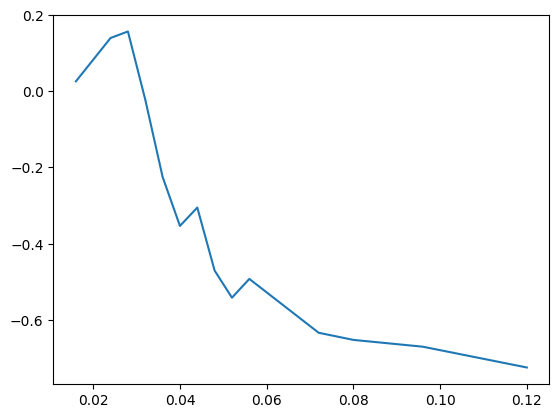

In [19]:
plt.plot(fixed_rates, deltas)

In [100]:
deltas_bump = [delta_bump(price[2], price[1], error) for price in all_values]

In [32]:
deltas_sim_bump.pop(3)

-0.1257917306225032

In [34]:
deltas_sim_bump.pop(7)

0.40248196713048295

In [81]:
deltas

[-0.015559854854851375, 0.00596214595563558, 0.042711015945172404]

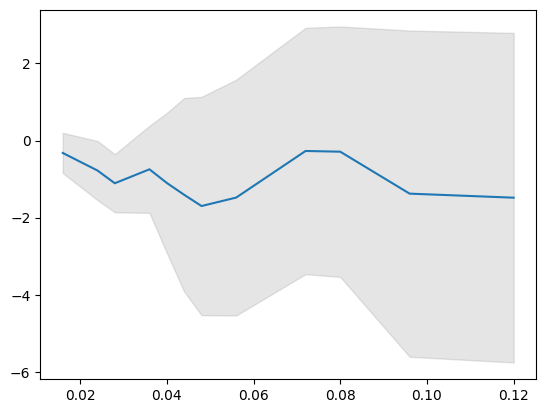

In [54]:
plt.plot(fixed_rates, deltas_sim)

lower_bound = [deltas_sim[i] - stdev_sim[i] for i in range(len(deltas_sim))]
upper_bound = [deltas_sim[i] + stdev_sim[i] for i in range(len(deltas_sim))]

plt.fill_between(fixed_rates, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')

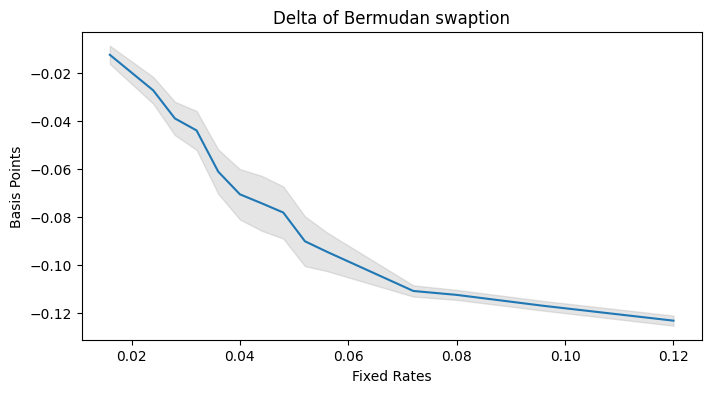

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(fixed_rates, deltas_sim)

lower_bound = [deltas_sim[i] - stdev_sim[i] for i in range(len(deltas_sim))]
upper_bound = [deltas_sim[i] + stdev_sim[i] for i in range(len(deltas_sim))]

plt.ylabel('Basis Points')
plt.xlabel('Fixed Rates')
plt.title('Delta of Bermudan swaption')

plt.fill_between(fixed_rates, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')

### Gamma

In [21]:
def central_difference_gamma(price_higher, price_middle, price_lower, epsilon):
    return (price_higher - 2*price_middle + price_lower) / (epsilon ** 2)

In [23]:
gammas_sim = list()
stdev_gammas_sim = list()
for i in range(len(fixed_rates)):
    temp_gamma = list()
    for j in range(total_sim):
        temp_gamma.append(central_difference_gamma(all_values[i][j][2], all_values[i][j][1], all_values[i][j][0], error))
    print(f'{i} is done')
    gammas_sim.append(np.mean(temp_gamma))
    stdev_gammas_sim.append(stats.sem(temp_gamma))

0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done


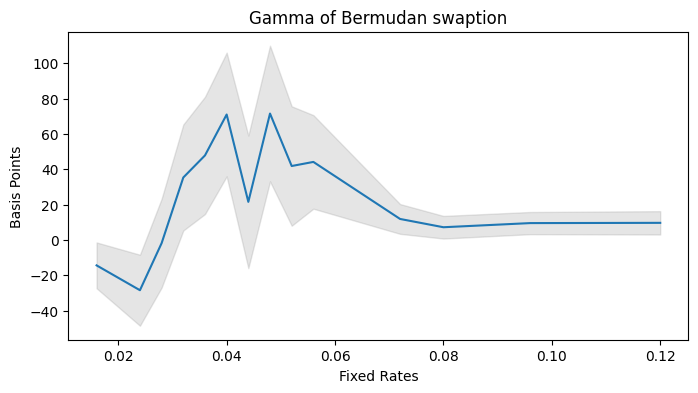

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(fixed_rates, gammas_sim)

lower_bound = [gammas_sim[i] - stdev_gammas_sim[i] for i in range(len(gammas_sim))]
upper_bound = [gammas_sim[i] + stdev_gammas_sim[i] for i in range(len(gammas_sim))]

plt.ylabel('Basis Points')
plt.xlabel('Fixed Rates')
plt.title('Gamma of Bermudan swaption')

plt.fill_between(fixed_rates, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')

### European Delta

In [25]:
def price_european_MC(swap_values, T_n, forward_rates):
    positive_swaps = list()
    for i in range(len(swap_values)):
        if swap_values[i] > 0:
            disc_rate = np.sum(forward_rates[i, int(T_n)])
            positive_swaps.append(swap_values[i]* np.exp(- disc_rate))
        else:
            positive_swaps.append(0)
    return sum(positive_swaps) / len(swap_values)

In [ ]:
# european_values = list()
# for fixed in fixed_rates:
#     eur_prices = list()
#     for i in range(len(yield_curves)):
#         # Get Bermudan Value
#         simulations_swap_values = get_simulations_swap_values(simulations, days_per_year, T_m, tenor, N, fixed, short_rates[i], yield_curves[i], a, sigma)[:,0]
#         eur = price_european_MC(simulations_swap_values, 1, forward_rates[i])
#         eur_prices.append(bermudan)
#     print(f'{fixed} done')
#     all_values.append(bermudan_prices)

In [26]:
european_values = list()
for fixed in fixed_rates:
    temp_list = list()
    for j in range(len(short_rates_sim)):
        eur_prices = list()
        for i in range(len(yield_curves)):
            simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed, short_rates_sim[j][i], yield_curves[i], a, sigma)[:,0]
            eur = price_european_MC(simulations_swap_values, 1, forward_rates_sim[j][i])
            eur_prices.append(eur)
        temp_list.append(eur_prices)
    print(f'{fixed} done')
    european_values.append(temp_list)

0.016 done
0.024 done
0.027999999999999997 done
0.032 done
0.036000000000000004 done
0.04 done
0.044000000000000004 done
0.048 done
0.052000000000000005 done
0.055999999999999994 done
0.07200000000000001 done
0.08 done
0.096 done
0.12 done


In [27]:
deltas_sim_eur = list()
stdev_sim_eur = list()
for i in range(len(fixed_rates)):
    temp_delta = list()
    for j in range(total_sim):
        temp_delta.append(central_difference_delta(european_values[i][j][2], european_values[i][j][0], error))
    deltas_sim_eur.append(np.mean(temp_delta))
    stdev_sim_eur.append(stats.sem(temp_delta))

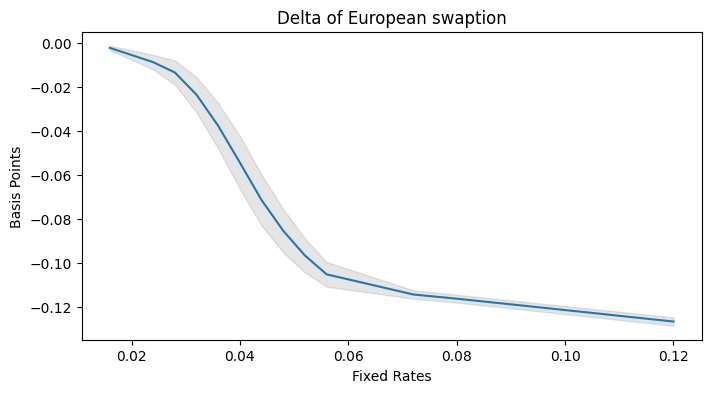

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(fixed_rates, deltas_sim_eur)

lower_bound = [deltas_sim_eur[i] - stdev_sim_eur[i] for i in range(len(deltas_sim_eur))]
upper_bound = [deltas_sim_eur[i] + stdev_sim_eur[i] for i in range(len(deltas_sim_eur))]

plt.ylabel('Basis Points')
plt.xlabel('Fixed Rates')
plt.title('Delta of European swaption')


plt.fill_between(fixed_rates, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')

In [54]:
def central_difference_gamma(price_higher, price_middle, price_lower, epsilon):
    return (price_higher - 2*price_middle + price_lower) / (epsilon ** 2)

In [29]:
gamma_sim_eur = list()
gamma_stdev_sim_eur = list()
for i in range(len(fixed_rates)):
    temp_gamma = list()
    for j in range(total_sim):
        temp_gamma.append(central_difference_gamma(european_values[i][j][2], european_values[i][j][1], european_values[i][j][0], error))
    gamma_sim_eur.append(np.mean(temp_gamma))
    gamma_stdev_sim_eur.append(stats.sem(temp_gamma))

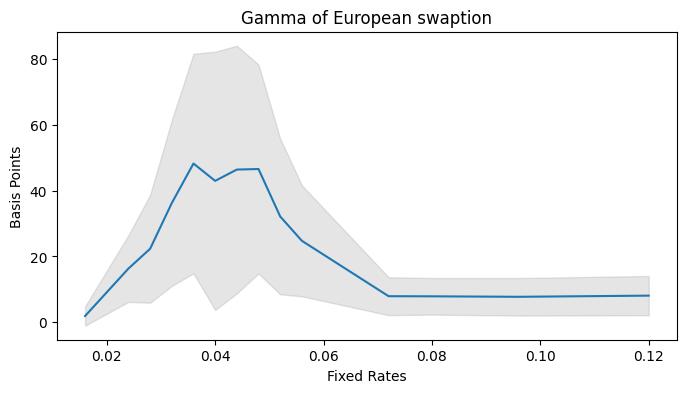

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(fixed_rates, gamma_sim_eur)

lower_bound = [gamma_sim_eur[i] - gamma_stdev_sim_eur[i] for i in range(len(gamma_sim_eur))]
upper_bound = [gamma_sim_eur[i] + gamma_stdev_sim_eur[i] for i in range(len(gamma_sim_eur))]

plt.ylabel('Basis Points')
plt.xlabel('Fixed Rates')
plt.title('Gamma of European swaption')


plt.fill_between(fixed_rates, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')